# An example SPEX session in Jupyter Notebook


In this example, we show how to do a spectral fit with the Python interface to SPEX (pyspex). The first thing we need to do is to start a SPEX session in Python. We do that by importing the Session class from pyspex.spex and then we create a Session instance ```s``` which will be the pointer to our SPEX session:

In [1]:
from pyspex.spex import Session
s = Session()
%matplotlib inline

 Welcome jellep to SPEX version 3.08.00
 
 NEW in this version of SPEX: 
21-04-2023 Added Quick CIE calculations (var calc qc)
21-04-2023 Added Shakura-Sunyaev model for accretion disk
04-03-2024 Added Speith model for relativistic broadening of lines
 
 Currently using SPEXACT version 2.07.00. Type `help var calc` for details.


## Reading a dataset

Let's first read in the example dataset, which is a spectrum and response for the future XIFU instrument aboard Athena. This is done by calling the session method ```data``` and provide the filename for the res and spo file:

In [2]:
s.data('xifu.res','xifu.spo')

0

Using a plot, we can see what the data look like. So let's make a log-log plot to look at the spectrum:

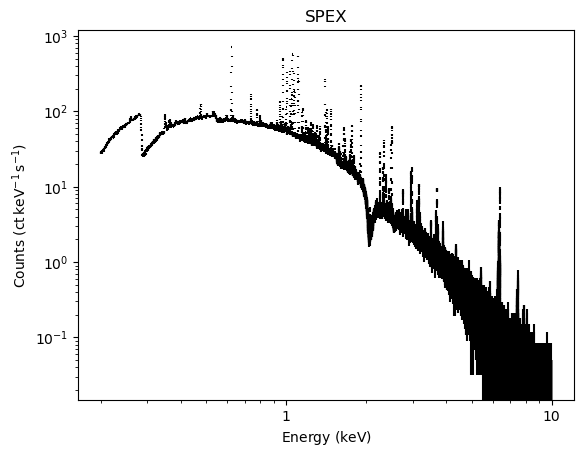

In [3]:
pldata = s.plot_data(xlog=True, ylog=True, show=True)

## Ignoring spectral energy ranges

The energy intervals below 0.2 keV and above 10 keV do not contain useful data, so let's ignore them:

In [4]:
s.ignore(1, 1, 0.0, 0.2, 'kev')
s.ignore(1, 1, 10.0, 100.0, 'kev')

## Creating a model and fit the data

To fit the data, we need to define a spectral model. This spectrum is a simulation of a galaxy cluster observation with XIFU, so we expect a thermal emission spectrum (CIE), Galactic absorption (hot) and a redshift. In the end, we need to tell SPEX the CIE model needs to be redshifted first and then absorbed by the Galaxy before it reaches the telescope:

In [5]:
import numpy
s.com('reds')
s.com('hot')
s.com('cie')
s.com_rel(1, 3, numpy.array([1, 2]))

 You have defined    1 component.
 You have defined    2 components.
 You have defined    3 components.


Now that the model is set, we need to provide initial guesses for the fit parameters. The simulated cluster has a redshift of 0.05 and the Galactic hydrogen column density is about 2E20 cm^-2. Since there are both Fe-L and Fe-K lines visible in the spectrum, we estimate that this cluster has an intermediate temperature (~4 keV):

In [6]:
s.dist(1, 0.05, 'z')                  # Set the distance in SPEX to z=0.05 (Luminosity).
s.par(1, 1, 'z', 0.05, thawn=True)    # Set the redshift in the model to z=0.05 (Energy shift in spectrum).
s.par(1, 2, 'nh', 2E-4)               # Set the hydrogen column density.
s.par_fix(1, 2, 't')                  # Fix the temperature of the galactic absorption to the default value
s.par(1, 3, 'norm', 1E+8, thawn=True) # Set a guess for the normalisation of the cluster component.
s.par(1, 3, 't', 4.0, thawn=True)     # Guess that the temperature is 4.0 keV.

 Distances assuming H0 =  70.0 km/s/Mpc, Omega_m = 0.300 Omega_Lambda = 0.700 Omega_r = 0.000
Sector       m      A.U.        ly        pc       kpc       Mpc  redshift        cz   age(yr)
----------------------------------------------------------------------------------------------
   1 6.859E+24 4.585E+13 7.250E+08 2.223E+08 2.223E+05  222.2891    0.0500   14989.6 6.738E+08
----------------------------------------------------------------------------------------------



The initial parameters are set, so we can see what our guessed model spectrum looks like compared to the data:

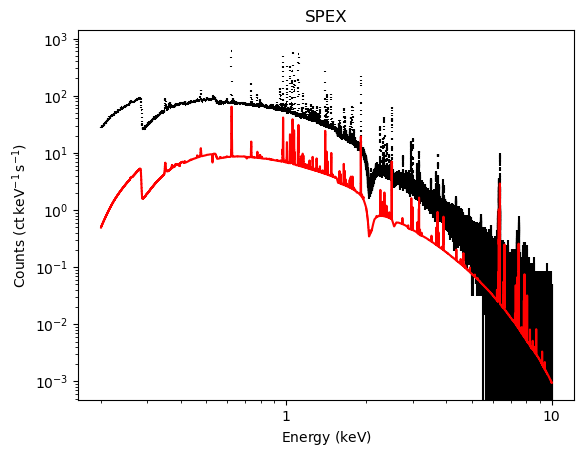

In [7]:
s.calc()
pldata = s.plot_data(xlog=True, ylog=True, show=True)

Apparently, our guess for the normalisation was too low, but it looks like the model is close enough to the data to attempt a fit: 

In [8]:
s.fit()
print(s.fit_cstat())

 fit iter  100                                                   
  2.841003E+07          4  5.000E-02  1.000E+08   4.00
 You cannot plot this frame since nothing is defined
 
  2.565890E+07         10  4.998E-02  1.126E+08   3.42
 You cannot plot this frame since nothing is defined
 
  2.150884E+07         14  4.994E-02  1.357E+08   2.68
 You cannot plot this frame since nothing is defined
 
  1.542377E+07         18  4.989E-02  1.836E+08   1.94
 You cannot plot this frame since nothing is defined
 
  8.670706E+06         22  4.986E-02  2.841E+08   1.64
 You cannot plot this frame since nothing is defined
 
  3.129318E+06         26  4.986E-02  4.866E+08   1.87
 You cannot plot this frame since nothing is defined
 
   762800.             30  4.985E-02  7.848E+08   2.41
 You cannot plot this frame since nothing is defined
 
   705524.             34  4.984E-02  8.482E+08   2.55
 You cannot plot this frame since nothing is defined
 
   705481.             38  4.984E-02  8.488E+0

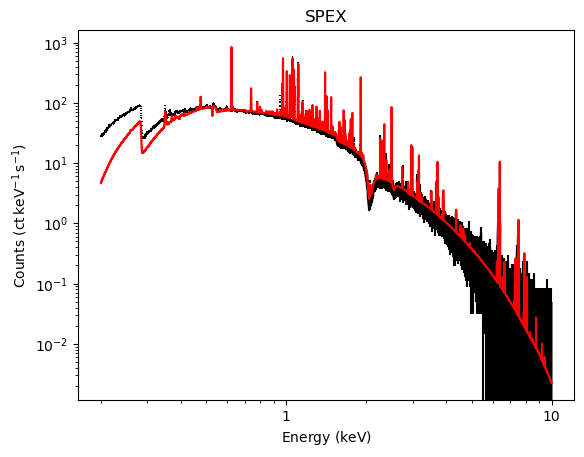

In [9]:
pldata = s.plot_data(xlog=True, ylog=True, show=True)

In the fit, we apparently forgot to free the Galactic absorption, so we try again:

 fit iter  100                                                   
   705481.              5  4.984E-02  2.000E-04  8.488E+08   2.55
 You cannot plot this frame since nothing is defined
 
   212525.             10  4.984E-02   0.00      7.462E+08   2.58
 You cannot plot this frame since nothing is defined
 
   209778.             15  4.984E-02   0.00      7.583E+08   2.57
 You cannot plot this frame since nothing is defined
 
   209778.             20  4.984E-02   0.00      7.583E+08   2.57
 You cannot plot this frame since nothing is defined
 
 Parameter    2 is at lower limit. Suggestion: fit again
 
--------------------------------------------------------------------------------------------------
sect comp mod  acro parameter with unit     value      status    minimum   maximum lsec lcom lpar

   1    1 reds z    Redshift             4.9844436E-02 thawn    -1.0      1.00E+10
   1    1 reds flag Flag: cosmo=0, vel=1  0.000000     frozen    0.0       1.0

   1    2 hot  nh   X-Col

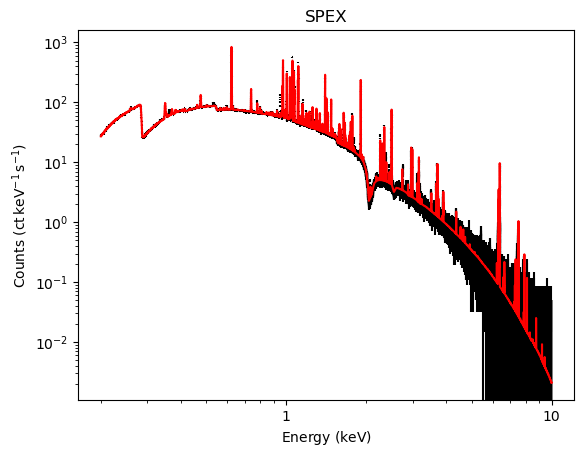

In [10]:
s.par_free(1, 2, 'nh')
s.fit()
print(s.fit_cstat())
pldata = s.plot_data(xlog=True, ylog=True, show=True)

Unfortunately, the fit is still rather bad. In our model, we are actually using the SPEXACT 2 model, but with XIFU we have such a high spectral resolution that we need more up-to-date models. So, we set SPEX to use the SPEXACT version 3 models (the fit can take a while...). 

 QC mode: quick evaluation for CIE-family models
 fit iter  100                                                   
   70174.4              5  4.984E-02   0.00      7.583E+08   2.57
 You cannot plot this frame since nothing is defined
 
   45550.4             10  5.000E-02   0.00      7.435E+08   2.52
 You cannot plot this frame since nothing is defined
 
   45482.4             15  5.000E-02   0.00      7.450E+08   2.52
 You cannot plot this frame since nothing is defined
 
 Parameter    2 is at lower limit. Suggestion: fit again
 
--------------------------------------------------------------------------------------------------
sect comp mod  acro parameter with unit     value      status    minimum   maximum lsec lcom lpar

   1    1 reds z    Redshift             5.0002024E-02 thawn    -1.0      1.00E+10
   1    1 reds flag Flag: cosmo=0, vel=1  0.000000     frozen    0.0       1.0

   1    2 hot  nh   X-Column (1E28/m**2)  0.000000     thawn     0.0      1.00E+20
   1    2 hot  

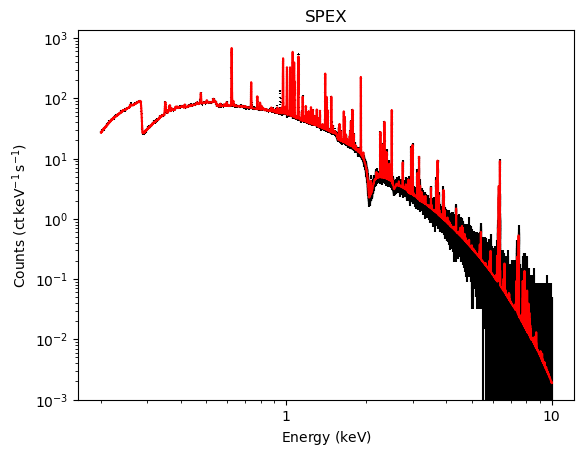

In [11]:
s.var_calc(True)
s.fit()
print(s.fit_cstat())
pldata = s.plot_data(xlog=True, ylog=True, show=True)

Now the C-statistics values look a lot better. Is this a good fit? Check a copy of this notebook and see if you can improve it even more.